# **CA4 @ AI Spring 2025**
# Convolutional vs. Fully Connected Neural Networks

- **Name:**
- **Student ID:**

---
Your submission should be named using the following format: `AI_CA4_LASTNAME_STUDENTID.ipynb`.

---

 *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says `WRITE YOUR ANSWER HERE` with your actual answer.
---
If you have any further questions or concerns, contact the TAs via email or Telegram.

# Introduction
In this assignment, you will compare fully connected neural networks with convolutional neural networks to evaluate whether convolutional architectures offer superior performance—and understand the reasons behind any observed differences.

**Important Note:**

Before you begin, please make sure to review the accompanying PyTorch tutorial provided alongside this file.

## Colab Setup

If you are running this notebook on Google Colab, you can mount your Google Drive using the following code to access or upload files directly from your Drive.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'AIS25-CA4')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


## Device

As demonstrated in the PyTorch tutorial, PyTorch enable you to run your code on GPU to accelerate computations.

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)),
])

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision

batch_size = 512

initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainset, valset = random_split(initial_trainset, [45000, 5000])

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valloader = DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [ ]:
# inverse the normilize transform to restore the original data
import torch

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor, gray=False, coeff=(0.3, 0.59, 0.11)):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        return tensor * self.std + self.mean

norminv = UnNormalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))

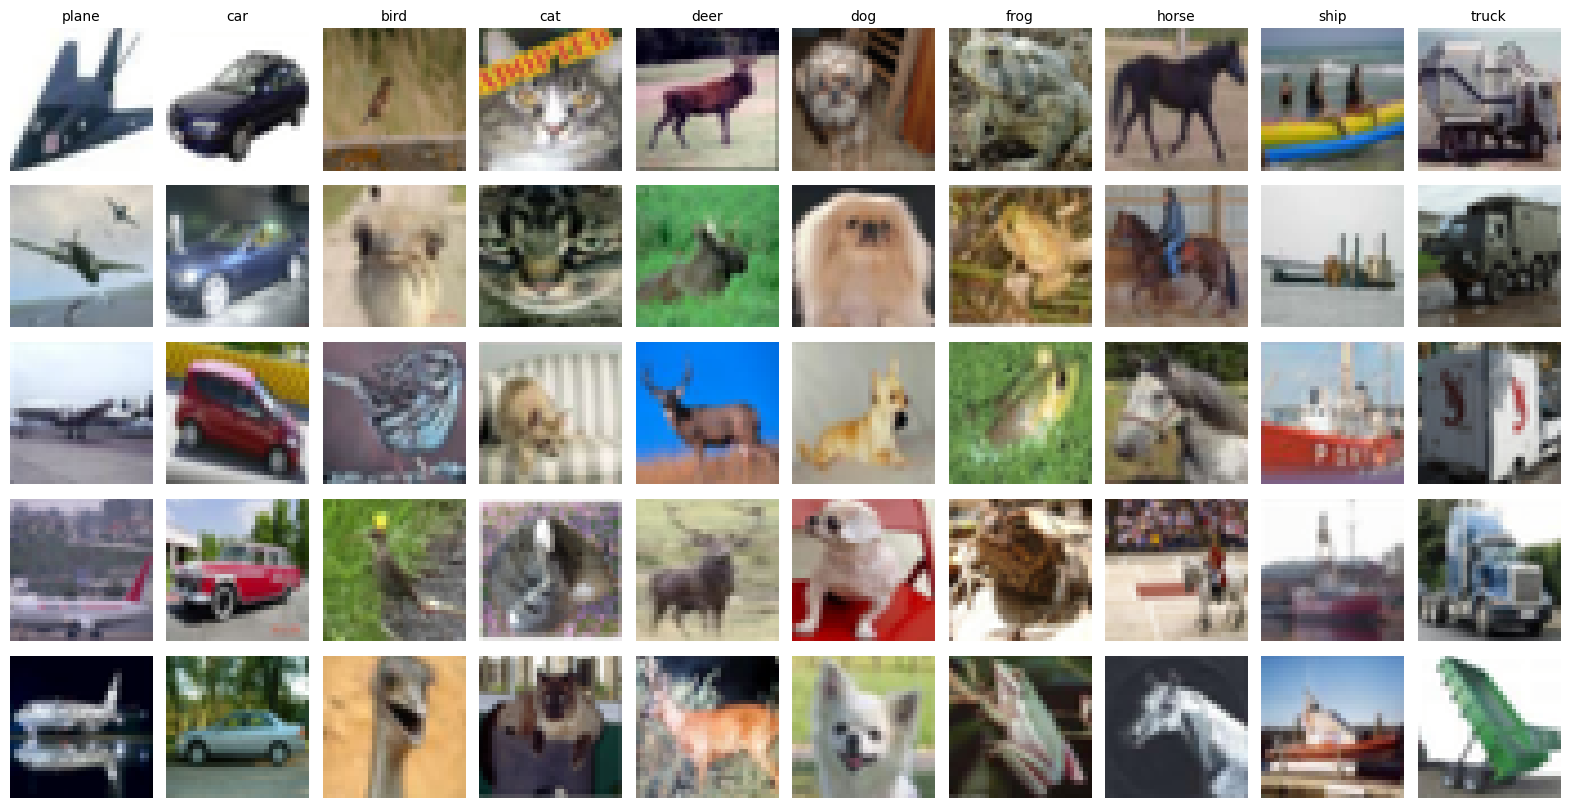

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import random

class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(trainset):
    class_to_indices[label].append(idx)

num_samples_per_class = 5
sample_indices_per_class = {}
for cls_idx in range(10):
    all_indices = class_to_indices[cls_idx]
    sample_indices_per_class[cls_idx] = random.sample(all_indices, num_samples_per_class)

fig, axes = plt.subplots(
    nrows=num_samples_per_class,
    ncols=len(classes),
    figsize=(2 * len(classes), 2 * num_samples_per_class),
    sharex=True,
    sharey=True
)

for col, cls_idx in enumerate(range(10)):
    for row, sample_idx in enumerate(sample_indices_per_class[cls_idx]):
        img_tensor, label = trainset[sample_idx]
        img_unnorm = norminv(img_tensor).clamp(0.0, 1.0)
        np_img = img_unnorm.permute(1, 2, 0).cpu().numpy()

        ax = axes[row, col]
        ax.imshow(np_img)
        ax.axis('off')

    axes[0, col].set_title(classes[cls_idx], fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Fully Connected Neural Netwrok

Your first task is to build a fully connected neural network with PyTorch. To achieve this, it is recommended that you familiarize yourself with the following PyTorch components and incorporate them into your network architecture:

* [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html)
* [`nn.Sequential`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
* [`nn.Linear`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)
* [`nn.ReLU`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
* [`nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* [`nn.Flatten`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In the provided template below, the final layer of the model should be defined separately and assigned the name `linear`, as it will be referenced in a later section of this assignment.

To ensure a fair comparison with convolutional neural networks (CNNs), both models should have approximately the same number of trainable parameters. Specifically, the fully connected model should contain **33,500,000 ± 500,000** trainable parameters.

You will calculate the exact number of trainable parameters in the following subsection to ensure this requirement is met.




In [ ]:
import torch
import torch.nn as nn

class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(FullyConnectedNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1   = nn.Linear(3 * 32 * 32, 4096)
        self.bn1   = nn.BatchNorm1d(4096)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.fc2   = nn.Linear(4096, 4096)
        self.bn2   = nn.BatchNorm1d(4096)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)

        self.fc3   = nn.Linear(4096, 1024)
        self.bn3   = nn.BatchNorm1d(1024)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.3)

        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = self.drop2(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop3(self.relu3(self.bn3(self.fc3(x))))
        x = self.linear(x)
        return x


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

$$\text{Layer 1} = \text{Weights} + \text{Biases} = (3072 \times 4096) + 4096 = 12587008 $$
$$\text{Layer 2} = \text{Weights} + \text{Biases} = (4096 \times 4096) + 4096 = 16781312 $$
$$\text{Layer 3} = \text{Weights} + \text{Biases} = (4096 \times 1024) + 1024 = 4195328 $$
$$\text{Layer 4} = \text{Weights} + \text{Biases} = (1024 \times 10) + 10 = 10250 $$
$$ \text{Total} = 33573898 $$

Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(FullyConnectedNetwork().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 4096]      12,587,008
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 1024]       4,195,328
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                   

## Train

### Model Instantiation

Create an instance of your model and move it to your selected device (CPU or GPU). Refer to the PyTorch-tutorial notebook for guidance on how to perform this operation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FullyConnectedNetwork(input_shape=(3, 32, 32), num_classes=10).to(device)

### Criterion & Optimizer


To train a neural network, we require a **loss function** (referred to as the *criterion*) to quantify the difference between the model's predictions and the true labels. This loss is then used to compute the gradients of the model parameters.

In addition, an **optimization algorithm** is needed to update the model's parameters using the calculated gradients, in order to minimize the loss over time.

You are encouraged to read about the following PyTorch components:

* [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* [`torch.optim.Adam`](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
def train_epoch(net: torch.nn.Module,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                dataloader: torch.utils.data.DataLoader):
    net.train()

    device = next(net.parameters()).device

    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size

        _, preds = torch.max(outputs, dim=1)
        running_correct += (preds == labels).sum().item()
        total_samples += batch_size

    avg_loss = running_loss / total_samples
    accuracy = 100.0 * (running_correct / total_samples)

    return avg_loss, accuracy


def eval_epoch(net: torch.nn.Module,
               criterion: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               test_mode: bool = False):
    net.eval()

    device = next(net.parameters()).device

    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size

            _, preds = torch.max(outputs, dim=1)
            running_correct += (preds == labels).sum().item()
            total_samples += batch_size

    avg_loss = running_loss / total_samples
    accuracy = 100.0 * (running_correct / total_samples)

    return avg_loss, accuracy


As previously mentioned, ensuring a fair comparison between models requires consistency in certain aspects of the training setup. One key factor is the number of **trainable parameters**, and another is the number of times the model processes the entire dataset—referred to as an **epoch**.

To maintain consistency in training duration across models, **do not modify** the `epochs` variable defined below.


In [ ]:
epochs = 60 # Do not modify

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}


for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 1.7121; train acc: 38.96%; val loss: 1.5224; val_acc: 44.96%
(Epoch 2 / 60) train loss: 1.4637; train acc: 47.56%; val loss: 1.4478; val_acc: 48.02%
(Epoch 3 / 60) train loss: 1.3556; train acc: 51.69%; val loss: 1.4108; val_acc: 49.64%
(Epoch 4 / 60) train loss: 1.2758; train acc: 54.61%; val loss: 1.3550; val_acc: 51.32%
(Epoch 5 / 60) train loss: 1.2101; train acc: 56.79%; val loss: 1.3372; val_acc: 51.80%
(Epoch 6 / 60) train loss: 1.1454; train acc: 58.93%; val loss: 1.2852; val_acc: 54.62%
(Epoch 7 / 60) train loss: 1.0928; train acc: 61.14%; val loss: 1.2909; val_acc: 54.78%
(Epoch 8 / 60) train loss: 1.0438; train acc: 62.62%; val loss: 1.3005; val_acc: 54.08%
(Epoch 9 / 60) train loss: 0.9956; train acc: 64.36%; val loss: 1.2869; val_acc: 55.70%
(Epoch 10 / 60) train loss: 0.9508; train acc: 65.86%; val loss: 1.2918; val_acc: 56.38%
(Epoch 11 / 60) train loss: 0.8957; train acc: 67.86%; val loss: 1.2901; val_acc: 56.28%
(Epoch 12 / 60) train loss: 0.

### Save Model

Save the trained model for use in subsequent sections to avoid retraining it later.


In [ ]:
torch.save(model.state_dict(), "fully-connected.pth")

In [ ]:
# model.load_state_dict(torch.load('fully-connected.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

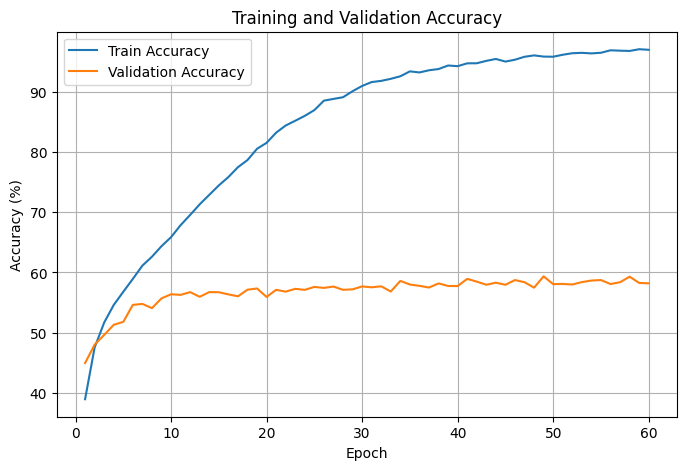

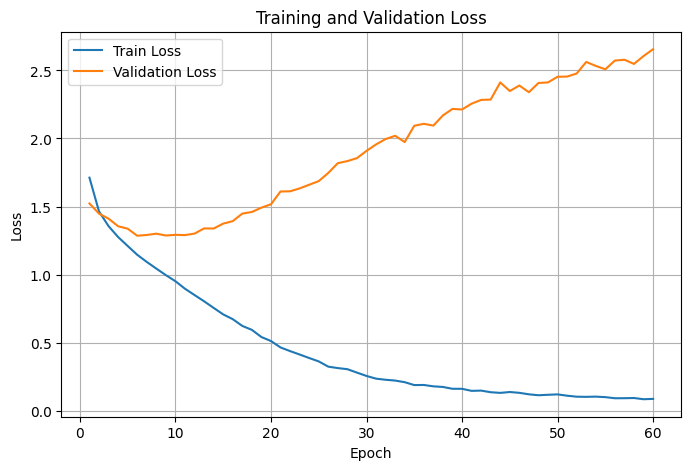

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `60%`

In [ ]:
test_loss, test_acc = eval_epoch(model, criterion, testloader, test_mode=True)

print(f"Test Loss: {test_loss:.4f}; Test Accuracy: {test_acc:.2f}%")

Test Loss: 2.6205; Test Accuracy: 58.51%


# Convolutional Neural Network

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

 You are encouraged to learn about the following core components commonly used in convolutional neural networks:

* [`nn.Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [`nn.MaxPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**Reminder**: The model you define should contain 33,500,000 ± 500,000 trainable parameters.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding=2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn_conv4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(256 * 8 * 8, 1856)
        self.bn_dense1 = nn.BatchNorm1d(1856)
        self.fc2 = nn.Linear(1856, 928)
        self.bn_dense2 = nn.BatchNorm1d(928)
        self.fc3 = nn.Linear(928, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def conv_layers(self, x):
        x = F.relu(self.bn_conv1(self.conv1(x)))
        x = F.relu(self.bn_conv2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)

        x = F.relu(self.bn_conv3(self.conv3(x)))
        x = F.relu(self.bn_conv4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(x)

        return x

    def dense_layers(self, x):
        x = F.relu(self.bn_dense1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_dense2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 256 * 8 * 8)
        out = self.dense_layers(out)
        return out


## Trainable params

Based on the defined architecture, manually calculate the total number of trainable parameters:

$$
- \text{Conv1}: (3·5·5·128) + 128 = 9 600 + 128 = 9 728  \\
- \text{BN1}: 128·2 = 256  \\
- \text{Conv2}: (128·5·5·128) + 128 = 409 600 + 128 = 409 728  \\
- \text{BN2}: 128·2 = 256  \\
- \text{Conv3}: (128·3·3·256) + 256 = 294 912 + 256 = 295 168  \\
- \text{BN3}: 256·2 = 512  \\
- \text{Conv4}: (256·3·3·256) + 256 = 589 824 + 256 = 590 080  \\
- \text{BN4}: 256·2 = 512  \\
- \text{FC1}: (256·8·8 ·1856) + 1856 = 30 408 704 + 1 856 = 30 410 560 \\
- \text{BN_dense1}: 1856·2 = 3 712  \\
- \text{FC2}: (1856·928) + 928 = 1 722 368 + 928 = 1 723 296  \\
- \text{BN_dense2}: 928·2 = 1 856  \\
- \text{FC3}: (928·10) + 10 = 9 280 + 10 = 9 290  \\
$$
Summing up:  
$$9 728 + 256 + 409 728 + 256 + 295 168 + 512 + 590 080 + 512  
+ 30 410 560 + 3 712 + 1 723 296 + 1 856 + 9 290
= 33 454 954 $$ trainable parameters.


Once you have completed your hand calculation, you can verify your result by running the following cell:

In [ ]:
from torchsummary import summary
summary(CNN().to(device), input_size=(3, 32, 32));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           9,728
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         409,728
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         MaxPool2d-5          [-1, 128, 16, 16]               0
         Dropout2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
       BatchNorm2d-8          [-1, 256, 16, 16]             512
            Conv2d-9          [-1, 256, 16, 16]         590,080
      BatchNorm2d-10          [-1, 256, 16, 16]             512
        MaxPool2d-11            [-1, 256, 8, 8]               0
        Dropout2d-12            [-1, 256, 8, 8]               0
           Linear-13                 [-1, 1856]      30,410,560
      BatchNorm1d-14                 [-

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = CNN(num_classes=10).to(device)

### Criterion & Optimizer

Define `criterion` and `optimizer`

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-4)

### Train loop

Train your model

Tasks:
- Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
epochs = 60 # Do not modify
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, trainloader)
    val_loss, val_acc = eval_epoch(model, criterion, valloader)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"(Epoch {epoch + 1} / {epochs}) train loss:{train_loss: .4f}; train acc:{train_acc: .2f}%; val loss:{val_loss: .4f}; val_acc:{val_acc: .2f}%")

(Epoch 1 / 60) train loss: 3.3197; train acc: 15.45%; val loss: 2.0074; val_acc: 25.74%
(Epoch 2 / 60) train loss: 2.0310; train acc: 23.63%; val loss: 1.8216; val_acc: 31.58%
(Epoch 3 / 60) train loss: 1.8874; train acc: 28.44%; val loss: 1.6870; val_acc: 38.02%
(Epoch 4 / 60) train loss: 1.7814; train acc: 32.62%; val loss: 1.5668; val_acc: 42.58%
(Epoch 5 / 60) train loss: 1.6866; train acc: 36.54%; val loss: 1.4849; val_acc: 44.42%
(Epoch 6 / 60) train loss: 1.6041; train acc: 40.48%; val loss: 1.3495; val_acc: 49.98%
(Epoch 7 / 60) train loss: 1.5198; train acc: 44.33%; val loss: 1.2642; val_acc: 53.62%
(Epoch 8 / 60) train loss: 1.4410; train acc: 47.68%; val loss: 1.2397; val_acc: 53.50%
(Epoch 9 / 60) train loss: 1.3536; train acc: 50.77%; val loss: 1.1095; val_acc: 59.86%
(Epoch 10 / 60) train loss: 1.2822; train acc: 54.22%; val loss: 1.0461; val_acc: 62.74%
(Epoch 11 / 60) train loss: 1.2041; train acc: 57.26%; val loss: 0.9432; val_acc: 67.54%
(Epoch 12 / 60) train loss: 1.

### Save Model

Since changes need to be made to the model later on, it is advisable to save your model to avoid having to retrain it in case of any issues.

In [ ]:
torch.save(model.state_dict(), "cnn.pth")

In [ ]:
# model.load_state_dict(torch.load('cnn.pth'))

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

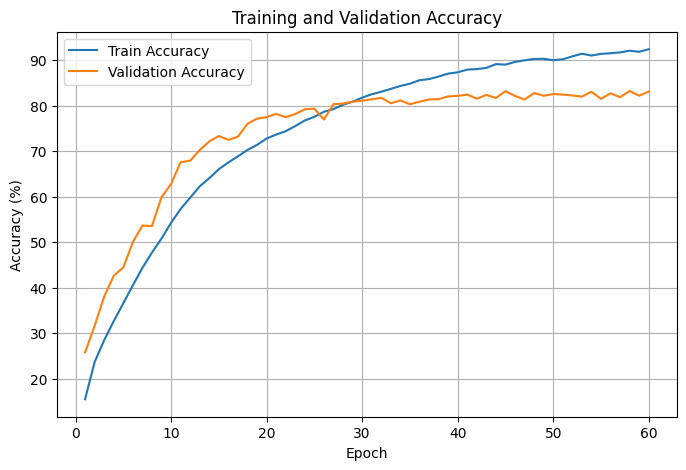

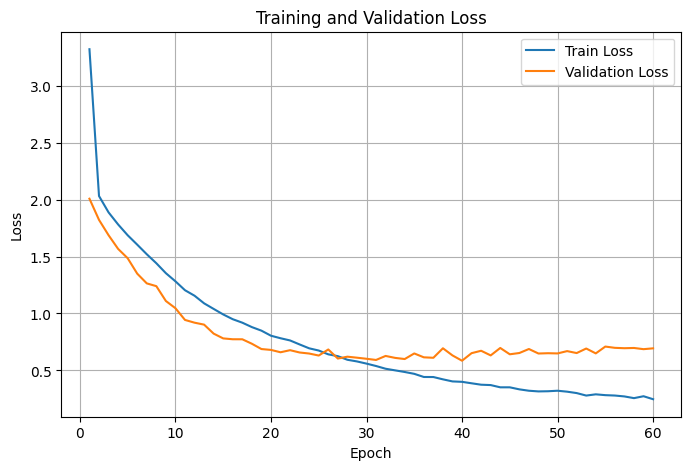

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [ ]:
model.eval()
running_loss = 0.0
running_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        _, preds = torch.max(outputs, dim=1)
        running_correct += (preds == labels).sum().item()
        total_samples += batch_size

test_loss = running_loss / total_samples
test_acc = 100.0 * running_correct / total_samples

print(f"Test Loss: {test_loss:.4f}; Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.7478; Test Accuracy: 82.19%



## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model. Note that if you used normalization in the transform function for loading the data, you will need to unnormalize the images before displaying them.

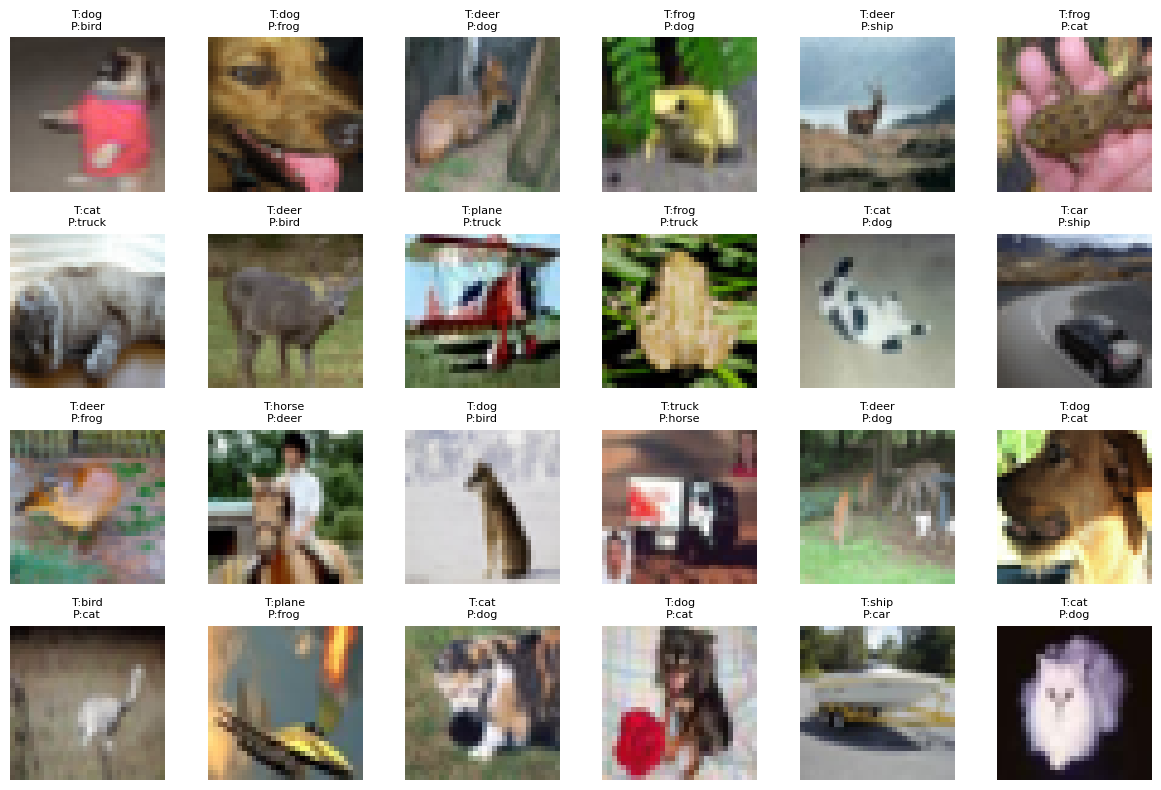

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

mean = np.array([0.4914, 0.4822, 0.4465])
std  = np.array([0.2470, 0.2435, 0.2616])

def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1,2,0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

misclassified_images = []
misclassified_preds  = []
misclassified_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        wrong_mask = (preds != labels)
        if wrong_mask.any():
            wrong_imgs   = images[wrong_mask].cpu()
            wrong_preds  = preds[wrong_mask].cpu()
            wrong_labels = labels[wrong_mask].cpu()

            misclassified_images.append(wrong_imgs)
            misclassified_preds.append(wrong_preds)
            misclassified_labels.append(wrong_labels)

if len(misclassified_images) > 0:
    misclassified_images = torch.cat(misclassified_images, dim=0)
    misclassified_preds  = torch.cat(misclassified_preds, dim=0)
    misclassified_labels = torch.cat(misclassified_labels, dim=0)
else:
    raise RuntimeError("No misclassified samples found! Check that testloader/model are correct.")

N_wrong = misclassified_images.shape[0]
if N_wrong < 24:
    print(f"Only found {N_wrong} misclassified samples. Will display all of them.")
    chosen_indices = list(range(N_wrong))
else:
    chosen_indices = random.sample(range(N_wrong), 24)

fig, axes = plt.subplots(4, 6, figsize=(12, 8))
axes = axes.flatten()

for idx_plot, idx in enumerate(chosen_indices):
    img_tensor = misclassified_images[idx]
    pred_label = misclassified_preds[idx].item()
    true_label = misclassified_labels[idx].item()

    img_np = unnormalize(img_tensor)

    ax = axes[idx_plot]
    ax.imshow(img_np)
    ax.axis("off")
    ax.set_title(f"T:{classes[true_label]}\nP:{classes[pred_label]}", fontsize=8)

for j in range(len(chosen_indices), 24):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(45000, N)` saved in a variable (for later usage)

- **Hint:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
import torch
from torch.utils.data import DataLoader

model.eval()

fs_loader = DataLoader(
    trainset,
    batch_size=512,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

feat_list = []
with torch.no_grad():
    for inputs, _ in fs_loader:
        inputs = inputs.to(device)
        x = model.conv_layers(inputs)
        x = x.view(-1, 256*8*8)
        x = model.dropout(F.relu(model.bn_dense1(model.fc1(x))))
        features = F.relu(model.bn_dense2(model.fc2(x)))
        feat_list.append(features.cpu())

feature_space = torch.cat(feat_list, dim=0)
print("Feature space shape:", feature_space.shape)

Feature space shape: torch.Size([45000, 928])


### K Nearest Neighbor in feature space

We already have calculated the feature spaces for trainset ($S$) in the previous section. Now we follow these steps to explore the featre space:

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

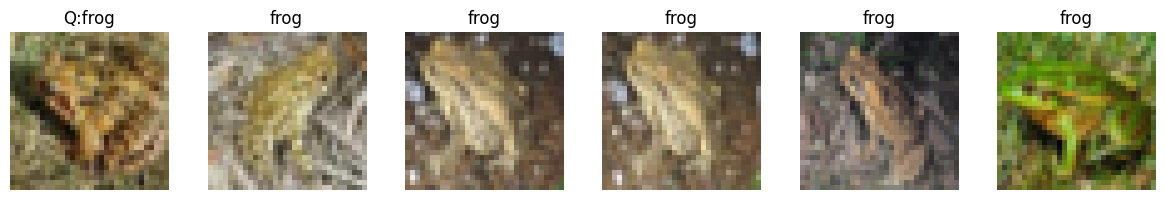

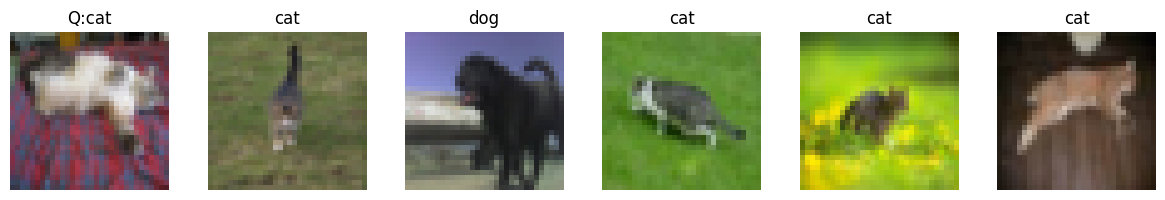

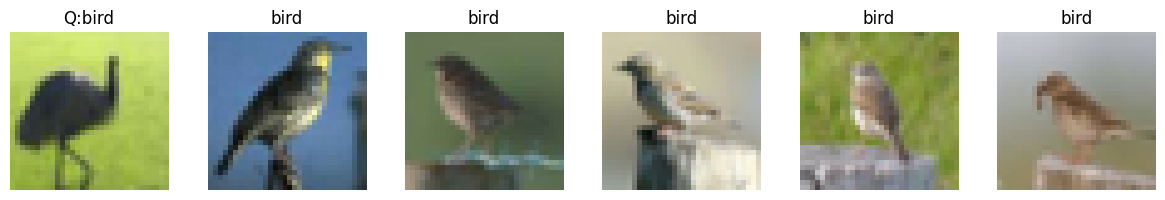

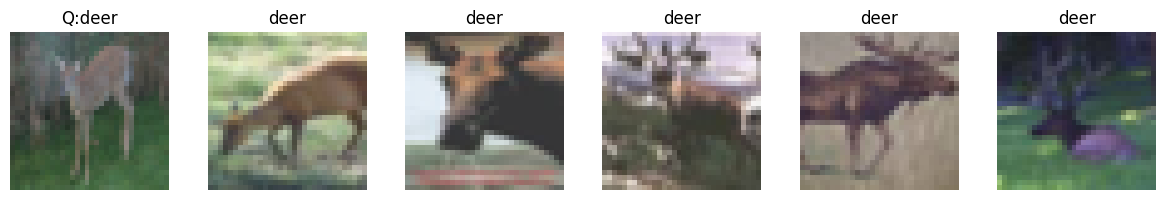

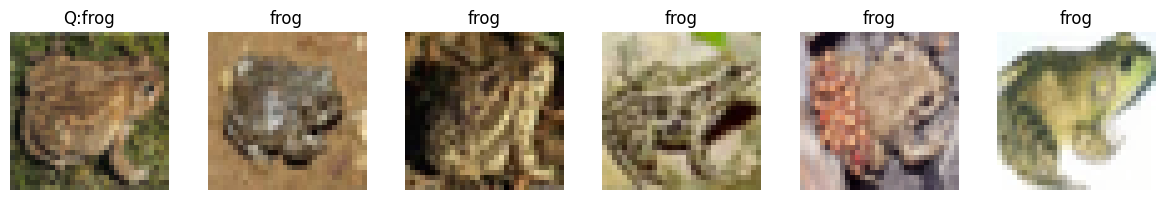

In [ ]:
import random
import matplotlib.pyplot as plt

model.eval()

correct_imgs, correct_labels = [], []
with torch.no_grad():
    for imgs, labs in testloader:
        imgs, labs = imgs.to(device), labs.to(device)
        preds = model(imgs).argmax(1)
        mask = preds == labs
        if mask.any():
            correct_imgs += imgs[mask].cpu().unbind(0)
            correct_labels += labs[mask].cpu().tolist()
        if len(correct_imgs) >= 5:
            break

idxs = random.sample(range(len(correct_imgs)), 5)
for i, idx in enumerate(idxs):
    q_img = correct_imgs[idx]
    q_lab = correct_labels[idx]

    with torch.no_grad():
        x = q_img.unsqueeze(0).to(device)
        x = model.conv_layers(x)
        x = x.view(-1, 256*8*8)
        x = model.dropout(F.relu(model.bn_dense1(model.fc1(x))))
        q_feat = F.relu(model.bn_dense2(model.fc2(x))).cpu()

    dists = torch.norm(feature_space - q_feat, dim=1)
    nbrs = dists.topk(5, largest=False).indices

    fig, axs = plt.subplots(1, 6, figsize=(12,2))
    def unnorm(t): return norminv(t).permute(1,2,0).numpy().clip(0,1)

    axs[0].imshow(unnorm(q_img)); axs[0].set_title(f"Q:{classes[q_lab]}"); axs[0].axis("off")
    for j, ni in enumerate(nbrs):
        tr_img, tr_lab = trainset[ni]
        axs[j+1].imshow(unnorm(tr_img)); axs[j+1].set_title(classes[tr_lab]); axs[j+1].axis("off")
    plt.tight_layout()
    plt.show()

### TSNE

Let's follow these steps to explore feature space even more:

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now we have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now we have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)


In [ ]:
from sklearn.manifold import TSNE

indices = np.random.randint(0, len(feature_space), 2000)
feature_space = feature_space[indices]
tsne = TSNE(n_components=2, random_state=42)
reduced_space = tsne.fit_transform(feature_space.reshape(feature_space.shape[0], -1).detach().cpu().numpy())

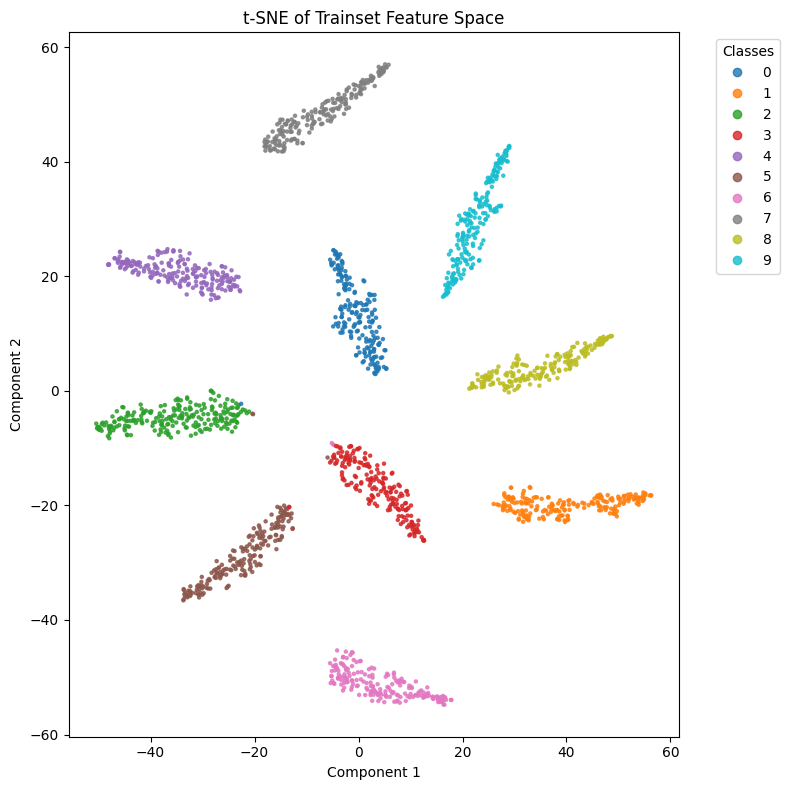

In [ ]:
labels = [trainset[i][1] for i in indices]

plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    reduced_space[:, 0],
    reduced_space[:, 1],
    c=labels,
    cmap='tab10',
    s=5,
    alpha=0.8
)
plt.legend(
    *scatter.legend_elements(num=10),
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title("t-SNE of Trainset Feature Space")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

### Feature Map


In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's select a random image from dataset.

In [ ]:
image = trainset[3][0]

Now, we are going to *clip* our model at different points to get different intermediate representation.
* Clip your model at least at one point and plot the filters output. You can use the output of first Resnet block.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 2 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



In [ ]:
import torch.nn as nn

clipped = nn.Sequential(
    model.conv1,
    model.bn_conv1,
    nn.ReLU()
).to(device)

with torch.no_grad():
    intermediate_output = clipped(image.unsqueeze(0).to(device))

In [ ]:
intermediate_output.shape

torch.Size([1, 128, 32, 32])

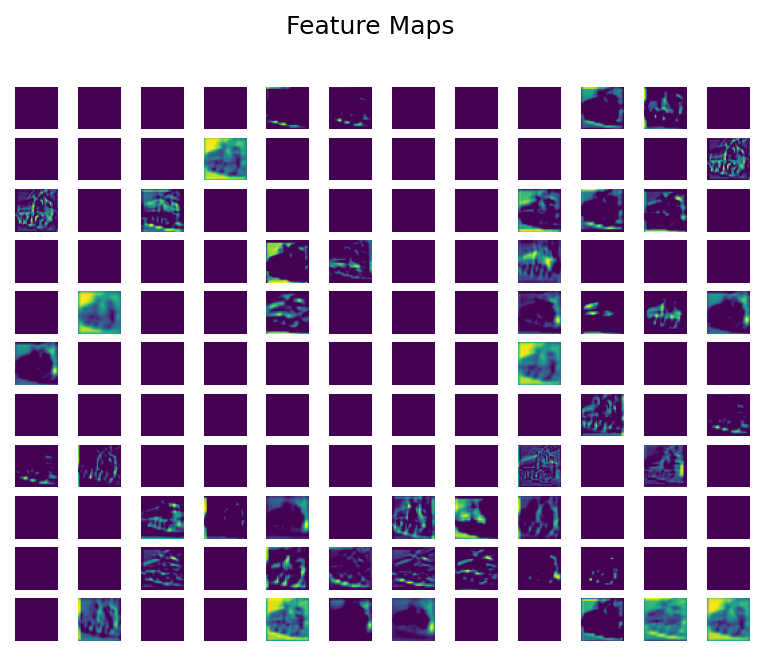

In [ ]:
import matplotlib.pyplot as plt
import math

def plot_intermediate_output(result, title=None):
    """
    Plots the intermediate output of shape
    N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

plot_intermediate_output(intermediate_output, title='Feature Maps')


**Note:** You are expected to analyze all results presented in this notebook and thoughtfully consider the underlying reasons behind them. Be prepared to discuss your insights during the **in-person review session**.
A written report is not required.
